<a href="https://colab.research.google.com/github/yukitiec/Research/blob/main/Watson_English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.9 MB/s eta 0:00:00


In [ ]:
import cv2 
import pandas as pd
import numpy as np
import glob
import os
import csv
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab.patches import cv2_imshow
import scipy.ndimage as ndimage

# Imports
import random
import transformers
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer

from transformers import BertTokenizer, TFBertModel

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Setup for TPU

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.99.246.34:8470
REPLICAS:  8


In [ ]:
%cd /content/gdrive/My Drive/WALC

/content/gdrive/My Drive/WALC


In [ ]:
%cd contradictory-my-dear-watson

/content/gdrive/My Drive/WALC/contradictory-my-dear-watson


#Load Data

In [ ]:
train_df = pd.read_csv('train_english.csv')
#test file
test_df = pd.read_csv('test_english.csv')
test_df

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian
...,...,...,...,...,...
5190,5f90dd59b0,نیند نے وعدہ کیا کہ موٹل نے سوال میں تحقیق کی.,نیمیتھ کو موٹل کی تفتیش کے لئے معاوضہ دیا جارہ...,ur,Urdu
5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock.,en,English
5192,1f0ea92118,她目前的存在，并考虑到他与沃佛斯顿争执的本质，那是尴尬的。,她在与Wolverstone的打斗结束后才在场的事实被看作是很尴尬的。,zh,Chinese
5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English


#Tokenize Text Data & IDs

In [ ]:
from transformers import AutoTokenizer

ModuleNotFoundError: ignored

In [ ]:
checkpoint = "bert-base-cased" #"jplu/tf-xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def encode(df, tokenizer, max_length=max_length):
    values = df[['premise', 'hypothesis']].values.tolist()    
    encodings = tokenizer.batch_encode_plus(values, padding='max_length', max_length=max_length, truncation=True)
    return encodings['input_ids']

In [ ]:
max_length = 259
train_encoded = encode(train_df,tokenizer=tokenizer,max_length=max_length)
test_encoded = encode(test_df,tokenizer=tokenizer,max_length=max_length)

#Model Construction

##Setting Class

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self)-> dict:
      """save constructor parameters, useful for model saving and loading
      Return:
        dict:model parameters
      """
      config = super().get_config()
      config.update({"embed_dim":self.embed_dim,
                     "dense_dim":self.ff_dim,
                     "num_heads":self.num_heads}
                    )
      
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    #serial for saving model
    def get_config(self):
      config = super().get_config()
      config.update({"output_dim":self.embed_dim,
                    "sequence_length":self.maxlen,
                    "input_dim":self.vocab_size} 
      )
      return config

##Build Model

In [ ]:
def build_model(input_size):
  embed_dim = 32  # Embedding size for each token
  num_heads = 2  # Number of attention heads
  ff_dim = 32  # Hidden layer size in feed forward network inside transformer

  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(20, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(2, activation="softmax")(x)

  #model = keras.Model(inputs=inputs, outputs=outputs)

  # Compiling the CNN
  opt = keras.optimizers.RMSprop()#Adam()
  model.compile(optimizer = opt, 
                    loss="binary_crossentropy",
                    metrics = ['accuracy']) 
  return model

In [ ]:
with strategy.scope():
    model = build_model()
    model.summary()

##Training

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("embeddings_bidir_Lstm.keras", save_best_only = True)]
history = model.fit(train_encoded[:7000,:], train_df.label.values[:7000], epochs = 100, verbose = 1, batch_size = 64, validation_split = 0.2)#,callbacks = callbacks)

##Evaluation

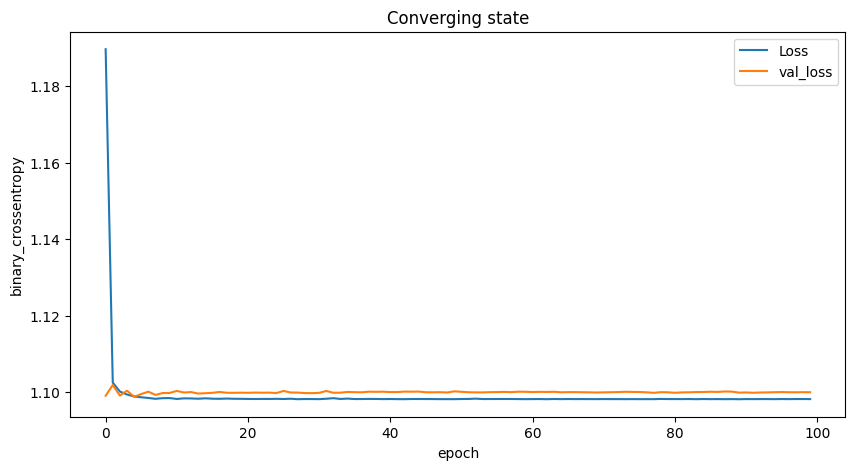

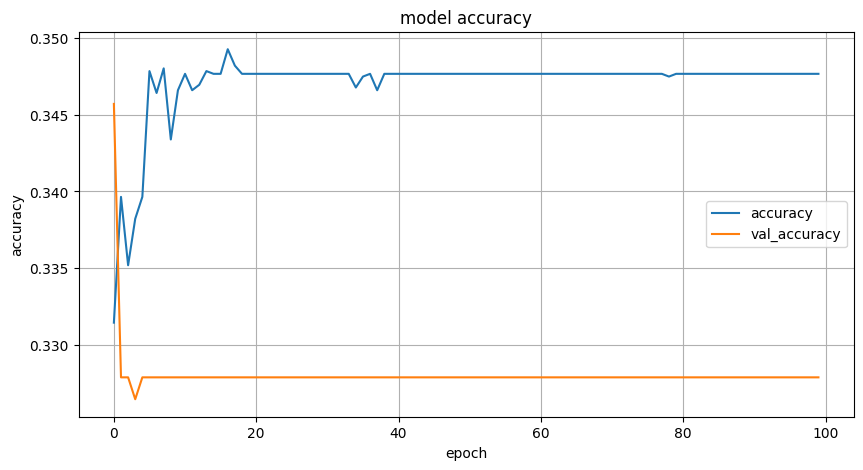

In [ ]:
#plot vonverging process : 
plt.subplots(figsize = (10,5))
plt.plot(history.history["loss"],label = "Loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.title("Converging state")
plt.xlabel("epoch")
plt.ylabel("binary_crossentropy")
plt.legend()
plt.show()

# Accuracy
plt.subplots(figsize = (10,5))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')  # Y軸ラベル
plt.xlabel('epoch')  # X軸ラベル
plt.grid()
plt.legend(loc='best')
plt.show()

##Prediction

In [ ]:
test_encoded = encode(test_df,tokenizer=tokenizer,max_length=max_length)

In [ ]:
# with strategy.scope():
y_preds = model.predict(test_encoded)
y_preds

len(y_preds[0]), len(test_df)

##Write to csv file

In [ ]:
df_sub = pd.read_csv('sample_submission.csv')
df_sub.head()

In [ ]:
df_sub['prediction'] = y_preds[0].argmax(axis=-1)
df_sub.describe()